By Srinath Sai Tripuraneni- A20338902.

In [1]:
!pip install pyspark #installing pyspark because I used pyspark for data filteration.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark import SparkContext, SparkConf
import numpy as np                          #importing necessary libraries and functions.
import matplotlib.pyplot as plt        

In [3]:
sc = SparkContext("local","Assignment-4: LF Model reccomendation") #initializing spark context 

In [4]:
trainRDD=sc.textFile('/content/training_dataset.csv').map(lambda x:x.split(",")) #as our datasets are in csv formatting splitting based on comma with the help of map function.


In [5]:
def take_required(x):
  required=[]
  required.append(x[0])
  required.append(x[1])  #Actually our dataset contains movie names also but for rmse that column is not required so filtering only first 3 functions.
  required.append(x[2])  #and this function is ownly defined to select first 3 columns.
  return required

In [6]:
trainRDD=trainRDD.map(lambda x : take_required(x)) #mapping every value by calling above defined function.

In [7]:
trainRDD=trainRDD.filter(lambda x : x[0]!='user_id') #in our csv file we get heading specifying which column is what. That headings are not required so filtering heading row.

In [8]:
def make_int(x):
  ans=[]
  for y in x :
    ans.append(int(y))  #while reading into rdd,it read as text format. so this function is created to convert every row into int append them and will be sent as list.
  return ans

In [9]:
trainRDD=trainRDD.map(lambda x : make_int(x)) #calling above function which converts every row into int and as a list ,so basically this
#is a rdd of list of list containg training dataset information.


In [10]:
userRDD=trainRDD.map(lambda x : (x[0])) #as first column is users taking first column from trainrdd with the help of map function.
itemsRDD=trainRDD.map(lambda x: (x[1])) #as second column is items, taking second column from trainrdd with the help of map function.
#why this step , you will understand in few minutes.

In [11]:
max_users=userRDD.max() #extracting maximum user count means that many users are there in the given dataset at maximum.
max_items=itemsRDD.max() #extracting maximum items from items rdd means given dataset has that many items at maximum.

In [12]:
users=set(userRDD.collect())# taking unique users.
items=set(itemsRDD.collect()) #taking unique items.

In [13]:
traindata=np.array(trainRDD.collect()) #converting trainRDD as numpy array for calculating.

In [14]:
del trainRDD   
del userRDD   #deleting all rdds for memory effiency and after converting to numpy array, we won't be using rdds therefore deleting them.
del itemsRDD


In [15]:
k=25 #given k for P and Q matrices as other dimension.
lamda =0.1 #given lamda.
iterations=40 # given iteration count.
learning_rate=0.002 #this is the challenging factor, as hyper parameter tunning is not allowed, did trial and error process many times and finally got better result of all values which is 0.002.
P = np.random.rand(max_users,k)*(np.sqrt(5/k))
Q = np.random.rand(max_items,k)*(np.sqrt(5/k))  #initialing P and Q matrices randomly with dimensions of max_users obtained above and max_items obtained above from 2 rdds.And values in
#range 0,rootof 5/k.
#link referedd fro intialing random numpy valuse:-
#https://stackoverflow.com/questions/26456180/initializing-a-matrix-with-random-number-from-given-range-python

In [16]:
def regularization(): #this function is created to compute regularization for every iteration.
  p_norm=0            #this function will return user_norm and items_norm.
  q_norm=0
  for i in P:
    for j in i:
      p_norm+=(j*j)   #this nested loop calculates user_norm by row wise of P matrix(dedicated to users.)
  for x in Q:
    for y in x:
      q_norm+=(y*y) #this nested loops calculates items_norm by row wise of Q matrix(dedicated to items).
  return p_norm,q_norm

In [17]:
def calculating_error(): #A function that is used for calculating error for every function.
  error_part=0
  for x in traindata:
    error_part+=pow((x[2]-np.dot(P[x[0]-1],Q[x[1]-1])),2) #here x[2] is orginal rating from numpy array of traindata and np.dot(P[x[0]-1],Q[x[1]-1]) is the product of value from P and Q for each row.
  users_norm,items_norm=regularization() #calling regularization function to prevent overfitting.
  error=error_part+(lamda*users_norm)+(lamda*items_norm) #adding lamda* norms obtained above as shown in main formula.
  return error #main error with regularization is returned.


In [18]:
error_per_iteration_cache={} #a hashmap is created for storing error as value and iteration count as keys.
for i in range(0,iterations): #40 iterations start here.
  for m in traindata: # idea is here first P and Q matrices are to be filled for every iteration and error function is computed after P and Q values get filled .
    P[m[0]-1]=P[m[0]-1]-(learning_rate*((lamda*P[m[0]-1])-2*(m[2]- np.dot(P[m[0]-1], Q[m[1]-1]))*(Q[m[1]-1]))) #filling of P and Q values iteratively and this two statements are direct translation of given formulas
    Q[m[1]-1]=Q[m[1]-1]-(learning_rate*((lamda*Q[m[1]-1])-2*(m[2]- np.dot(P[m[0]-1], Q[m[1]-1]))*(P[m[0]-1]))) 
  error_per_iteration_cache[i+1]=calculating_error() #filling hashmap according to the comment in the first line of defining hashmap.
  #note :- here traindata is numpy array of lists obtained from trainrdd. so every line oth index is user, 1st index is item and 2nd index is orginal rating but for filling in matrix I did by
  #P[m[0]-1],Q[m[1]-1] because matrices index starts from 0 not 1 if we do without subtracting by 1 I will be getting array index out of bounds.

In [19]:
iteration_counts=list(error_per_iteration_cache.keys()) # taking keys of hashmap which are iterations as list.
error_per_iteration=list(error_per_iteration_cache.values()) # taking values of hashmap into other list.

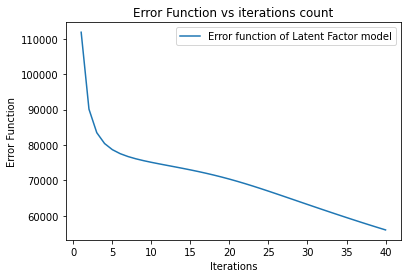

In [20]:
plt.plot(iteration_counts, error_per_iteration, label="Error function of Latent Factor model");
plt.title("Error Function vs iterations count");
plt.xlabel("Iterations"); 
plt.ylabel("Error Function");               #graphhing between error function value per iteration vs iterations count.
plt.legend(loc=0);

In [21]:
testdataRDD=sc.textFile('/content/test_dataset.csv').map(lambda x :x.split(",")) #now for preparing testdata we take it as textfile in rdd and map by splitting with comma.

In [22]:
testdataRDD=testdataRDD.map(lambda x: take_required(x))
testdataRDD=testdataRDD.filter(lambda x: x[0]!='user_id') #similar to trainrdd filtering header row, and taking only first 3 columns.

In [23]:
testdataRDD=testdataRDD.map(lambda x: make_int(x)) #making every value as int type from the above function for testdata.

In [24]:
testdata=np.array(testdataRDD.collect()) #converting testdata to np array for calculation.

In [25]:
user_all_ratings={user: [] for user in users} #initializing unique user as key and empty list as values.

In [26]:
for i in traindata:
  user_all_ratings[i[0]].append(i[2]) #this loop is madesuch that for every unique user there will be list of ratings rated by him as list and appended as value for particular user key.

In [27]:
average_user_rating={} #initializing a dictionary which will be user as key and average of each user rating as value.

In [28]:
for i in user_all_ratings:
  average_user_rating[i]=(sum(user_all_ratings[i])/len(user_all_ratings[i])) #computing average rating for each user.

In [29]:
predicted_ratings=[]
actual_ratings=[]
for x in testdata:                  
  if(x[1] not in items):   # A loop to have predicted ratings, actual ratings for calculation of RMSE.
    predicted_ratings.append(average_user_rating[x[0]])  #this if-else block is filling of predicted ratings from either dot product of particular user from P and particular item from Q
  else:                                                   #or from hashmap of average rating of user.
    predicted_ratings.append(np.dot(P[x[0]-1],Q[x[1]-1]))
  actual_ratings.append(x[2]) #here in testdata we take ratings to be actual ratings and it will be 2 nd element of each line from list of list from numpy array.

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def RMSE(y_actual, y_predicted):                       #a inbuilt function to calculate rmses of both predicted and actual ratings.
  rms = sqrt(mean_squared_error(y_actual, y_predicted))
  return round(rms,4)

In [31]:
RMSE(actual_ratings,predicted_ratings) #calling function for calculating list of predicted and actual ratings.

0.9195

In [32]:
predicted_ratings1=[]
actual_ratings1=[]
for x in testdata: #this loop is taking only values from dot product of P and Q of particular user, item  not taking from average rating of per user implying not using any average rating per user.
  predicted_ratings1.append(np.dot(P[x[0]-1],Q[x[1]-1]))
  actual_ratings1.append(x[2])

In [33]:
RMSE(actual_ratings1,predicted_ratings1) #calling again for values which have only from matrices P and Q.

0.9196